In [ ]:
import os
import keys # File with API keys
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain import hub
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from typing import Literal
from typing_extensions import Annotated
from langchain_core.prompts import PromptTemplate

In [ ]:
LOAD = True # load embeddings
SAVE = False # Save vector store

# set OpenAi key
os.environ["OPENAI_API_KEY"] = keys.OPENAI_API_KEY

# choose OpenAi model
llm = ChatOpenAI(model="gpt-4o-mini")

# choose OpenAi embeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# enable vector store
vector_store = InMemoryVectorStore(embeddings)

# Enable langsmith tracking
os.environ["LANGSMITH_TRACING"] = "true"

# Set langsmith key
os.environ["LANGSMITH_API_KEY"] = keys.LANGSMITH_API_KEY

In [ ]:
# Custom prompt
template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [ ]:
class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

In [ ]:
# Load txt data
with open("GroceryDataset.txt", encoding="utf8") as f:
    text = f.read()

#Split text
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

# Create document from data
all_splits = text_splitter.create_documents([text])

# Divide text into sections
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"

all_splits[0].metadata

# Enable vector store
vector_store = InMemoryVectorStore(embeddings)

# Index chunks
if LOAD:
    # load vector store
    vector_store.load('vector_store_query_analisys.pkl', embeddings)
else:
    # Create vector store with OpenAi model, create costs from model usage ~ 400k tokens
    _ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

# Define state for application
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

# Define application steps
def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

In [ ]:
# Save vector store
if SAVE:
    vector_store.dump('vector_store_from_CSVLoader.pkl') # save vector store to pkl

In [ ]:
# Test question and response
response = graph.invoke({"question": "I have a party soon, what are the best 5 snacks i can buy?"})
print(response["answer"])

For your party, consider these five snacks: Snyder's Mini Pretzels, Chex Mix Traditional Flavor, Pirates Booty Natural Aged White Cheddar, Ritz Bits Cheese Sandwich Crackers, and Cheez-It Crackers. These options provide a mix of savory, cheesy, and crunchy flavors that guests will enjoy. They are also conveniently packaged for easy serving.


In [ ]:
# Test question and response
response = graph.invoke({"question": "I have a party soon, what are the best 5 quick to prepare meals i can buy?"})
print(response["answer"])

You can consider ready-to-eat options like French-style prosciutto, smoked chicken breast, and andouille sausage for quick meals. Additionally, heritage pork applewood smoked ham and charcuterie selections can make for impressive party dishes. These items are convenient and perfect for entertaining guests.


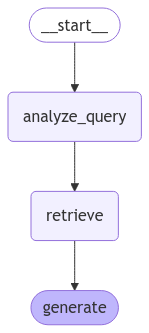

In [ ]:
from IPython.display import Image, display

# Display created workflow
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Show RAG steps
for step in graph.stream(
    {"question": "I have a party soon, what are the best 5 snacks i can buy?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'best party snacks', 'section': 'beginning'}}}

----------------

{'retrieve': {'context': [Document(id='f6ea51b4-bfa6-4e13-bd45-7d02fdc9ee77', metadata={'section': 'beginning'}, page_content='Deli,$59.99 ,No Discount,Rated 3.9 out of 5 stars based on 151 reviews.,"Fratelli Beretta Snack Pack, 2.5 oz, 10-pack",$,"10/ 2.5oz ON-THE-GO Snack Packs\nItalian Style Small Plate with 15g of Protein\nIncludes Uncured Prosciutto, Fontina and Crackers","Perfectly balanced, the prosciutto aged just right and produced to perfection - All natural with no added nitrates or nitrites. Mount Olive Italian Style Snacks, up to 15 grams of protein is sure to get you through your day. Mount Olive Italian Style Snacks, the ideal upscale snack for any occasion. The Italian Style Small Plate is a convenient option at mealtime or with a glass of wine to unwind. Grab a small plate and bring the taste of Italy right to your home, on the run and anywhere in between. Enjoy, La 